In [ ]:
def lower_bound(p, f, D, N):
    '''
    p = variational parameters
    f = log functions
    D = dataset
    N = number of samples
    '''
    mu, cov = p[:D], np.exp(p[:D])
    samples = npr.randn(N,D)*np.sqrt(cov)+mu
    result = mvn.entropy(mu, np.diag(cov))+np.mean(logprob(samples))
    
    return result



# Mean Field Variational Bayes


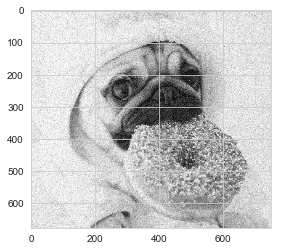

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import imageio
from scipy.misc import imread
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

noisy_img = imageio.imread('./figures/gaussian_noise.png')
plt.imshow(noisy_img, cmap='gray')


In [ ]:
J = 1  #coupling strength (w_ij)
prop = 0.7  #update smoothing rate
sigma  = 0.1  #noise level
max_iter = 15
ELBO = np.zeros(max_iter)
Hx_mean = np.zeros(max_iter)

logodds = multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2) - \
          multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2)
logodds = np.reshape(logodds, (M, N))

#init
p1 = sigmoid(logodds)
mu = 2*p1-1  #mu_init

a = mu + 0.5 * logodds
qxp1 = sigmoid(+2*a)  #q_i(x_i=+1)
qxm1 = sigmoid(-2*a)  #q_i(x_i=-1)

logp1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2), (M, N))
logm1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2), (M, N))

for i in tqdm(range(max_iter)):
    muNew = mu
    for ix in range(N):
        for iy in range(M):
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])            
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]            
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
            
            Sbar = J*np.sum(mu[nx,ny])       
            muNew[xx,yy] = (1-rate)*muNew[xx,yy] + rate*np.tanh(Sbar + 0.5*logodds[xx,yy])
            ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy])
        #end for
    #end for
    mu = muNew
            
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    Hx_mean[i] = np.mean(Hx) 